<a href="https://colab.research.google.com/github/inesamorim/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">
    
---
# Exploring Counterfactual Fairness under Gender Imbalance in Health Decision Models: From Diagnosis to Insurance Acceptance

</div>

---
## Problem Context
---

The rapid integration of artificial intelligence (AI) into health-related decision systems has introduced both opportunities for efficiency and risks of bias amplification. Predictive models trained on real-world medical data often inherit the structural imbalances and historical inequalities present in society. One of the most pervasive forms of such imbalance is gender bias: women have been historically under-represented or misrepresented in clinical datasets, leading to models that may perform less accurately or unfairly across genders.

In health diagnosis, AI models may systematically underpredict disease risk in female patients due to biased patterns in data collection, feature representation, or label assignment. For example, cardiovascular disease datasets, such as the UCI Heart Disease dataset, often contain a disproportionate number of male samples, which can cause diagnostic models to learn male-centric associations. This imbalance raises concerns about fairness and reliability when deploying such systems in real-world medical contexts, where misclassification can have serious ethical and clinical implications.

Similarly, in the domain of health insurance acceptance, algorithmic decision-making systems may propagate or even intensify these disparities. Models trained on socioeconomic and demographic attributes risk unfairly penalizing certain groups — such as women or minority populations — through indirect correlations between sensitive variables (like gender) and financial or medical risk indicators. This can lead to discriminatory outcomes in access to insurance, pricing, or policy approval.

The study of **counterfactual fairness** provides a principled approach to evaluate and mitigate such biases. Instead of merely comparing performance metrics between groups, counterfactual fairness examines whether an individual would have received the same model prediction had their sensitive attribute (e.g., gender) been different, all else being equal. By integrating counterfactual analysis into diagnostic and insurance decision models, this project aims to uncover the influence of gender imbalance on predictive behavior and explore methods for achieving fairer and more transparent health-related AI systems.

---
## Google Drive Set-Up
---

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!git clone https://github.com/inesamorim/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance.git /content/drive/MyDrive/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance

# Then just link it to the current working directory
%cd /content/drive/MyDrive/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance

/content/drive/MyDrive/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance


In [2]:
#%reload_ext autoreload
#%autoreload 2

In [1]:
from google.colab import output
output.enable_custom_widget_manager()

In [1]:
import os
os.chdir('/content/drive/MyDrive/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance')

In [ ]:
%pip install -r "./requirements.txt"

---
## Module Imports
---

In [2]:
from ucimlrepo import fetch_ucirepo #load the function to fetch datasets from UCI ML Repository
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *  #import all functions from utils.py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from witwidget.notebook.visualization import WitConfigBuilder, WitWidget
from data_auditor import DataProfiler, FairnessEngine

---
## 1. Data Overview
---

### 1.1 Heart Disease
---

In [3]:
# fetch dataset
heart_disease = fetch_ucirepo(id=45)


In [4]:
# data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets
X = pd.DataFrame(data=heart_disease.data.features, columns=heart_disease.feature_names)
y = pd.DataFrame(heart_disease.data.targets, columns=heart_disease.target_names)

# Combine
heart_disease_df = pd.concat([X, y], axis=1)
heart_disease_df.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

    ca  thal  num  
0  0.0   6.0    0  
1  3.0   3.0    2  
2  2.0   7.0    1  
3  0.0   3.0    0  
4  0.0   3.0    0

---
### 1.2. Health Insurance Acceptance
---

In [5]:
insurance_df = pd.read_csv('./datasets/healthinsurance.csv')
insurance_df.head()

age     sex  weight   bmi hereditary_diseases  no_of_dependents  smoker  \
0  60.0    male      64  24.3           NoDisease                 1       0   
1  49.0  female      75  22.6           NoDisease                 1       0   
2  32.0  female      64  17.8            Epilepsy                 2       1   
3  61.0  female      53  36.4           NoDisease                 1       1   
4  19.0  female      50  20.6           NoDisease                 0       0   

          city  bloodpressure  diabetes  regular_ex    job_title    claim  
0      NewYork             72         0           0        Actor  13112.6  
1       Boston             78         1           1     Engineer   9567.0  
2  Phildelphia             88         1           1  Academician  32734.2  
3    Pittsburg             72         1           0         Chef  48517.6  
4      Buffalo             82         1           0   HomeMakers   1731.7

---
## 2. Exploratory Data Analysis
---
### 2.1. Heart Disease
---

In [6]:
heart_disease_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


This study uses the **Cleveland Heart Disease Dataset** from the UCI Machine Learning Repository.
The dataset contains clinical and demographic attributes commonly used in heart disease diagnosis.
Below is a summary of the **14 selected attributes** (13 predictors + 1 target) used in this analysis:

| **Feature**                                        | **Description**                                                                                                                          | **Type / Range**      | **Notes**                                                      |
| -------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------- | --------------------- | -------------------------------------------------------------- |
| **age**                                            | Age of the patient in years.                                                                                                             | Continuous            | Represents risk factor increasing with age.                    |
| **sex**                                            | Biological sex (1 = male, 0 = female).                                                                                                   | Binary (categorical)  | Sensitive attribute used in fairness analysis.                 |
| **cp (chest pain type)**                           | Type of chest pain experienced. <br>1 = Typical angina <br>2 = Atypical angina <br>3 = Non-anginal pain <br>4 = Asymptomatic             | Categorical (1–4)     | Clinically relevant indicator of heart disease.                |
| **trestbps (resting blood pressure)**              | Resting blood pressure (mm Hg) measured upon hospital admission.                                                                         | Continuous            | Often used to assess hypertension.                             |
| **chol (serum cholesterol)**                       | Serum cholesterol in mg/dl.                                                                                                              | Continuous            | High levels are a known cardiac risk factor.                   |
| **fbs (fasting blood sugar)**                      | Fasting blood sugar >120 mg/dl (1 = true, 0 = false).                                                                                    | Binary                | Indicator of diabetes; related to cardiovascular risk.         |
| **restecg (resting electrocardiographic results)** | 0 = Normal <br>1 = ST-T wave abnormality <br>2 = Left ventricular hypertrophy                                                            | Categorical (0–2)     | Reflects electrical activity and possible heart abnormalities. |
| **thalach (maximum heart rate achieved)**          | Maximum heart rate reached during exercise.                                                                                              | Continuous            | Lower values may indicate cardiac limitation.                  |
| **exang (exercise-induced angina)**                | Whether exercise-induced angina occurred (1 = yes, 0 = no).                                                                              | Binary                | Associated with cardiac distress during exertion.              |
| **oldpeak**                                        | ST depression induced by exercise relative to rest.                                                                                      | Continuous            | Measures heart stress during physical activity.                |
| **slope**                                          | Slope of the peak exercise ST segment. <br>1 = Upsloping <br>2 = Flat <br>3 = Downsloping                                                | Categorical (1–3)     | Indicates heart function response to exercise.                 |
| **ca**                                             | Number of major vessels (0–3) colored by fluoroscopy.                                                                                    | Discrete              | Reflects vessel blockage; higher values = worse condition.     |
| **thal**                                           | Thalassemia test result. <br>3 = Normal <br>6 = Fixed defect <br>7 = Reversible defect                                                   | Categorical (3, 6, 7) | Diagnostic measure for blood-related cardiac issues.           |
| **num (target)**                                   | Diagnosis of heart disease (angiographic disease status). <br>0 = <50% narrowing (no disease) <br>1–4 = >50% narrowing (disease present) | Categorical (0–4)     | For modeling, values 1–4 are grouped as **1 (disease)**.       |



#### **Target**

/content/drive/MyDrive/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance/utils.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=feature, palette='Set2')


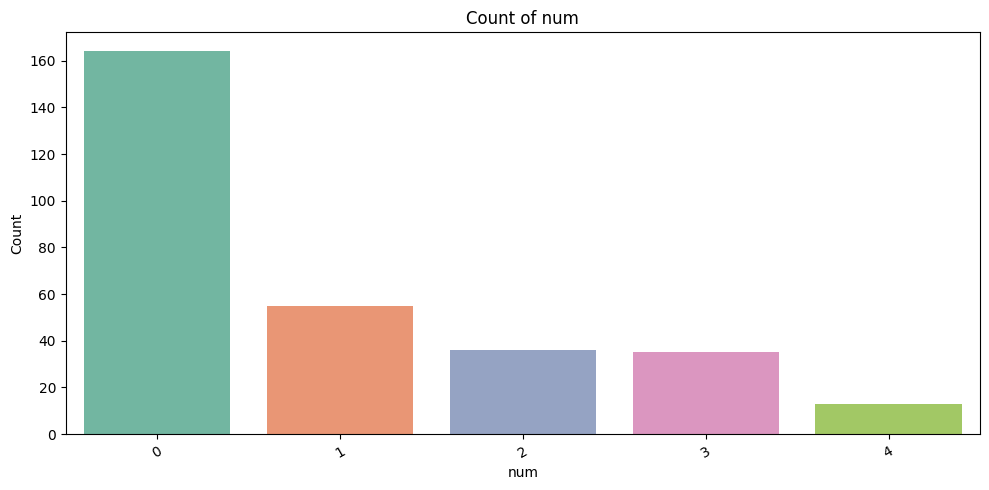

In [7]:
plot_feature_distribution_categorical(heart_disease_df, 'num')

The target variable ranges from 0 to 4, where 0 indicates no heart disease and values 1 through 4 represent increasing levels of disease severity. However, most studies and implementations based on this dataset simplify the problem into a binary classification task. Specifically, all non-zero values (1–4) are grouped together and treated as “disease present,” while 0 remains “no disease.” This transformation is widely adopted because the dataset is relatively small and the higher severity classes contain very few samples, which makes multi-class modeling unstable and prone to imbalance. Moreover, for most practical and clinical purposes, the key question is whether a patient has heart disease at all, rather than predicting the precise severity level. Converting the target variable to binary form therefore improves model reliability, simplifies interpretation, and aligns with the primary goal of identifying the presence of heart disease, which is especially relevant for fairness and counterfactual analysis.

In [8]:
# Collapse multi-class target into binary
heart_disease_df['HasHeartDisease'] = heart_disease_df['num'].apply(lambda x: 1 if x > 0 else 0)
heart_disease_df.drop(columns=['num'], inplace=True)
heart_disease_df['HasHeartDisease'].unique()

array([0, 1])

/content/drive/MyDrive/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance/utils.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=feature, palette='Set2')


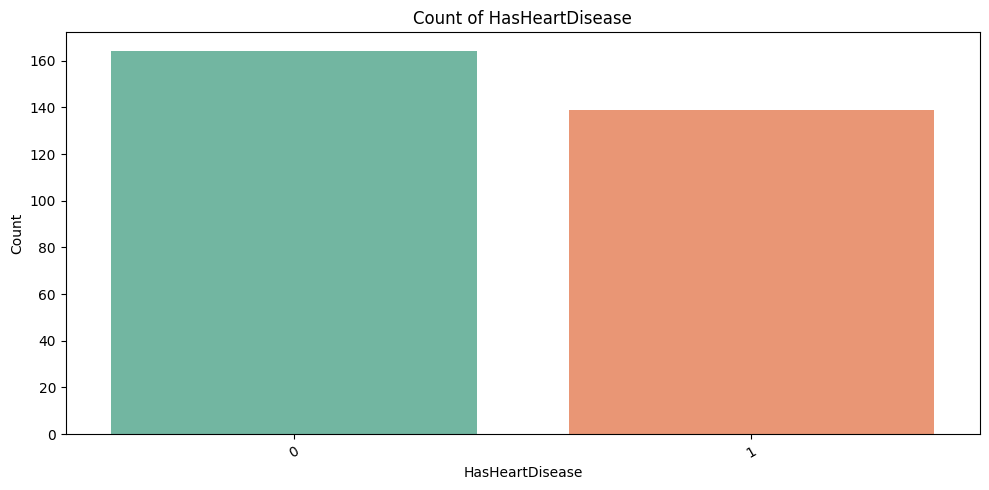

In [9]:
plot_feature_distribution_categorical(heart_disease_df, 'HasHeartDisease')

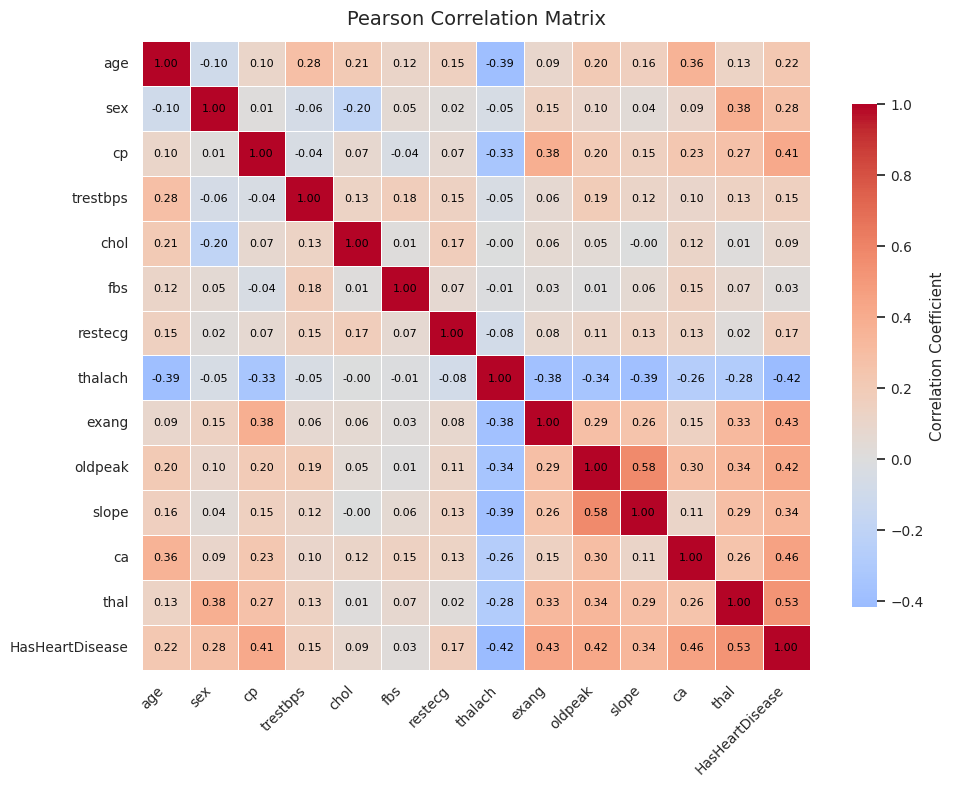

In [10]:
plot_correlation_matrix(heart_disease_df)

* **Strongest correlations with the target (`HasHeartDisease`):**

  * **thal (0.53)** → Indicates that thalassemia test results are strongly related to heart disease presence.
  * **ca (0.46)** → The number of major vessels visible via fluoroscopy is an important diagnostic indicator.
  * **exang (0.43)** → Exercise-induced angina is positively linked to heart disease, as expected.
  * **cp (0.41)** → Certain types of chest pain are more common in patients with heart disease.

* **Strong negative correlation:**

  * **thalach (–0.42)** → Maximum heart rate achieved is inversely related to disease risk; lower heart rates during exercise are associated with higher likelihood of heart disease.

* **Moderate or weak correlations:**

  * Features such as **age**, **chol**, and **restecg** show low correlation values, suggesting that their effects might be non-linear or only become significant when interacting with other variables.



#### **Categorical Features**

In [11]:
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
for feature in categorical_features:
    heart_disease_df[feature] = heart_disease_df[feature].astype('object')

3


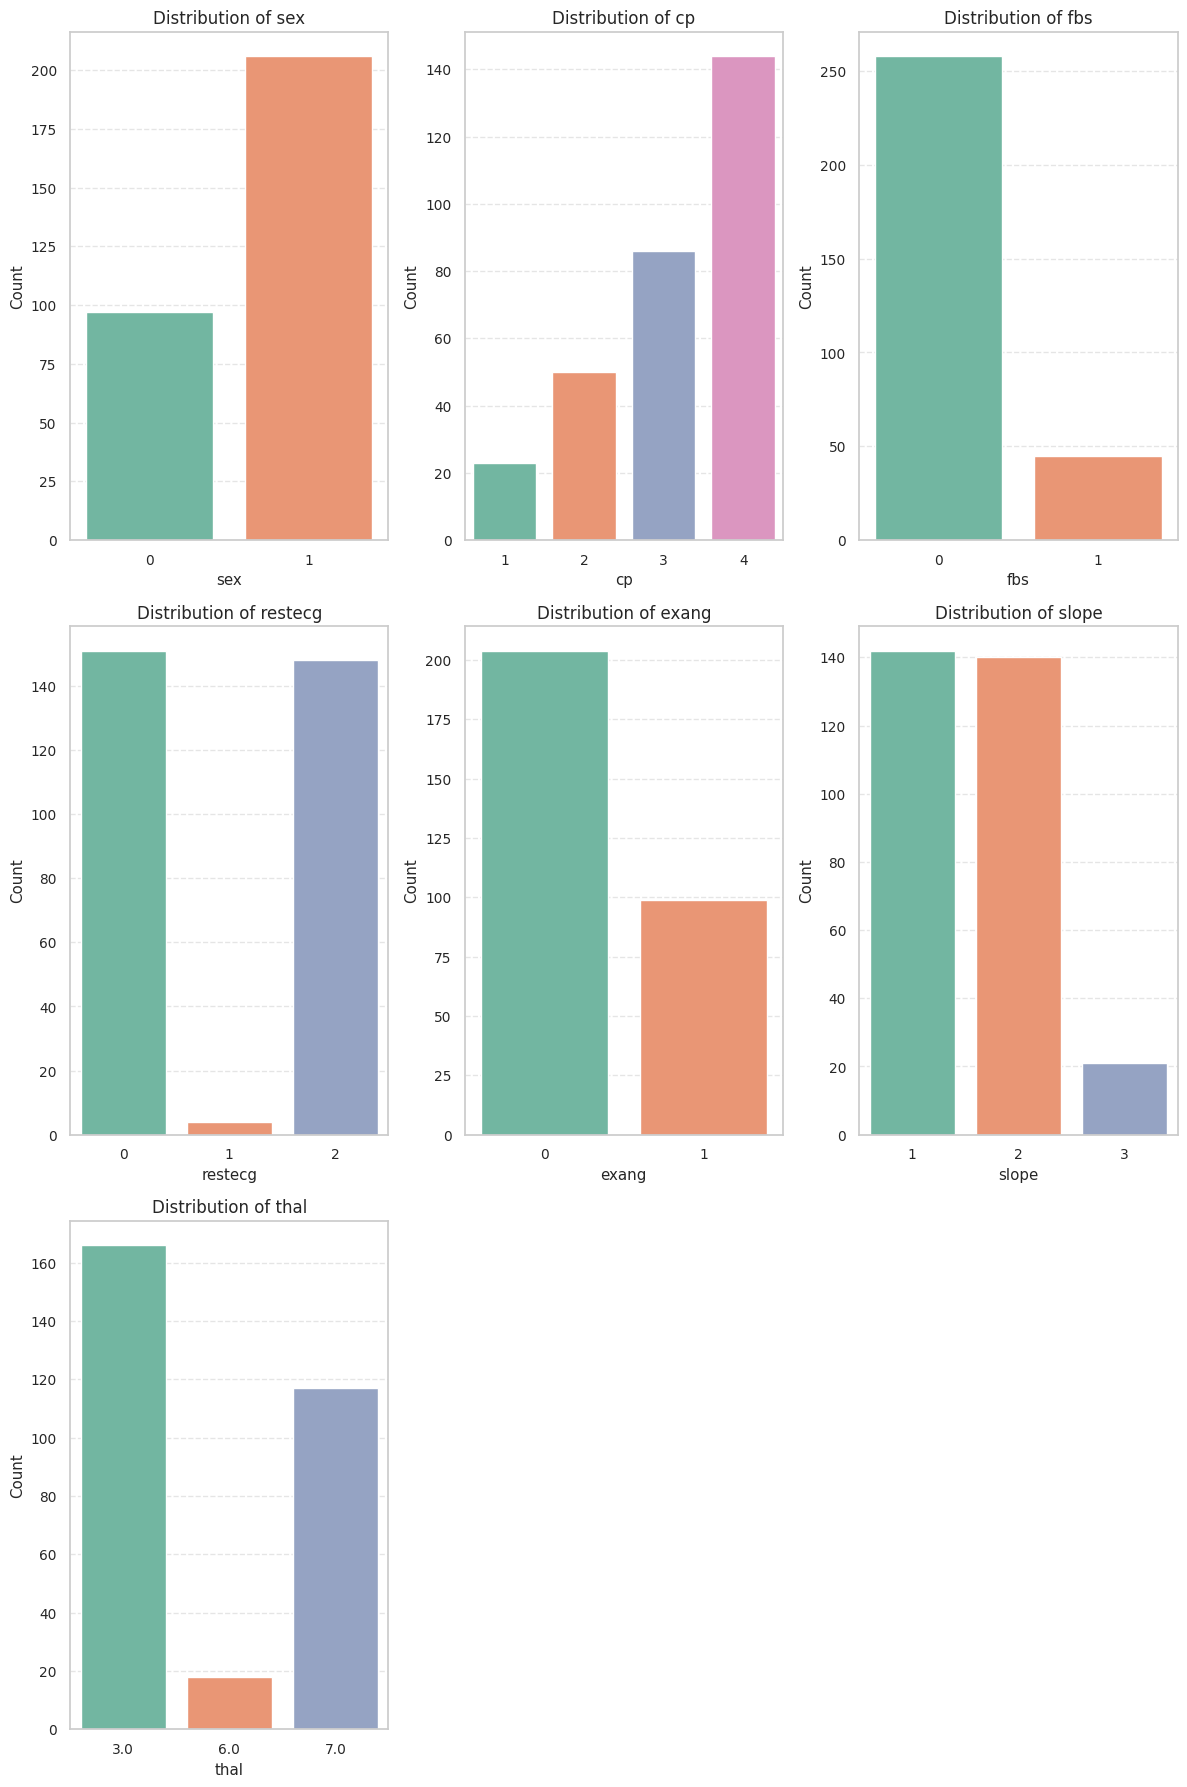

In [12]:
plot_feature_distributions(heart_disease_df, categorical_features)

/content/drive/MyDrive/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance/utils.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=feature, palette='Set2')


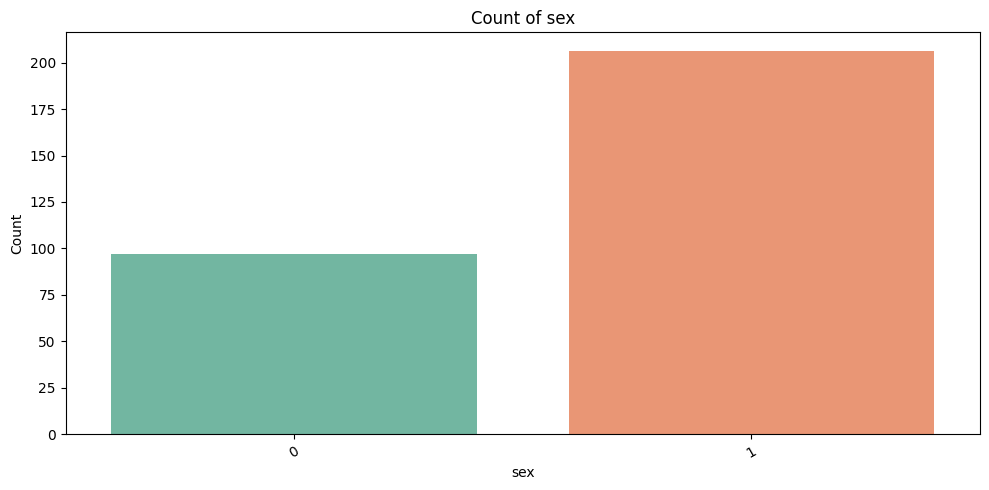

In [14]:
plot_feature_distribution_categorical(heart_disease_df, 'sex')

I will map out the sex for better understanding.
- 1: Male
- 0: Female

/content/drive/MyDrive/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance/utils.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=feature, palette='Set2')


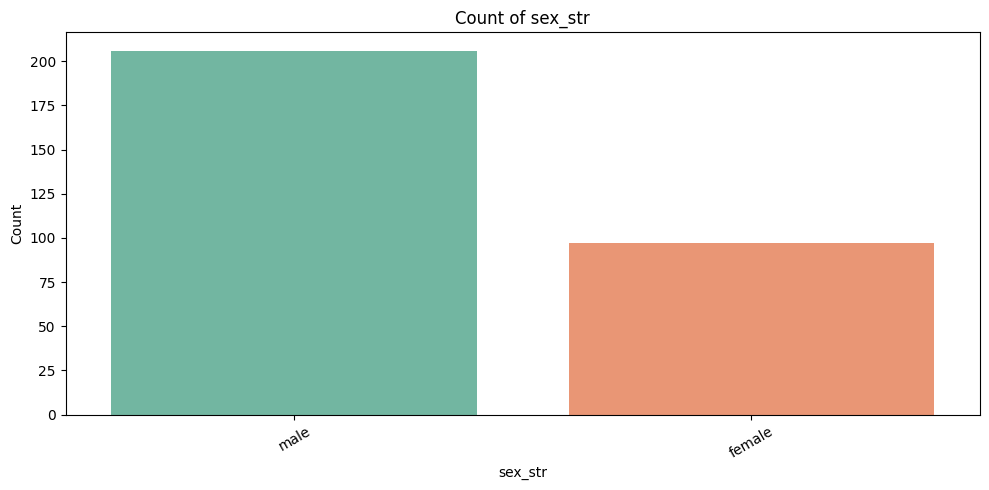

In [15]:
sex_mapping = {1: 'male', 0: 'female'}
heart_disease_df['sex_str'] = heart_disease_df['sex'].map(sex_mapping)
plot_feature_distribution_categorical(heart_disease_df, 'sex_str')

Since **sex** is a sensitive attribute that could introduce bias into the model, I will use the **DataAuditor** library to further investigate potential fairness issues and assess how this feature influences predictions.


In [17]:
heart_disease_profile = DataProfiler(df=heart_disease_df, target='HasHeartDisease')
heart_disease_profile.print_report()

n_samples: 303
n_features: 15
target: HasHeartDisease
num_cols: ['age', 'ca', 'chol', 'cp', 'exang', 'fbs', 'oldpeak', 'restecg', 'sex', 'slope', 'thal', 'thalach', 'trestbps']
cat_cols: ['sex_str']
mv_cols: ['ca', 'thal']
mv_percentage: 0.13
duplicate_rows: 0
target_distribution: {0: 0.54, 1: 0.46}


In [16]:
heart_disease_df['HasHeartDisease'] = heart_disease_df['HasHeartDisease'].astype('object')

In [18]:
heart_disease_engine = FairnessEngine(df=heart_disease_df, target='HasHeartDisease', sensitive_features=['sex'])

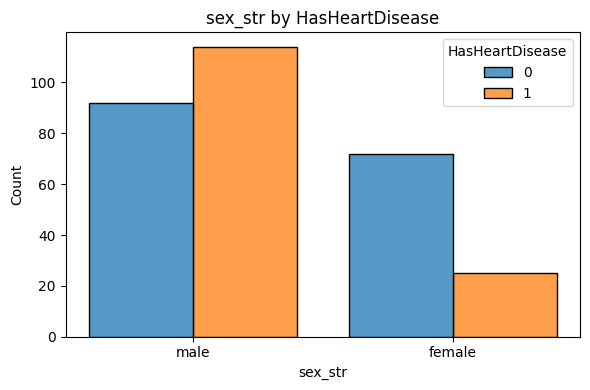

In [19]:
heart_disease_profile.plot_mult_histogram(col_names=['sex_str'], cols=1, hue='HasHeartDisease')

In [20]:
heart_disease_engine.target_rate_by_group_table(group='sex')

sex                  0      1
HasHeartDisease              
0                23.76  30.36
1                 8.25  37.62

/content/drive/MyDrive/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance/utils.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=feature, palette='Set2')


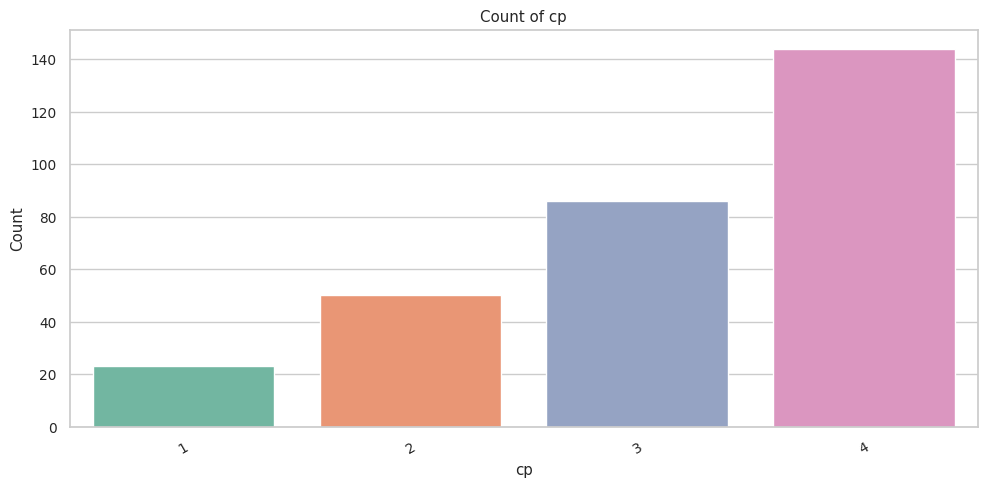

In [11]:
plot_feature_distribution_categorical(heart_disease_df, 'cp')

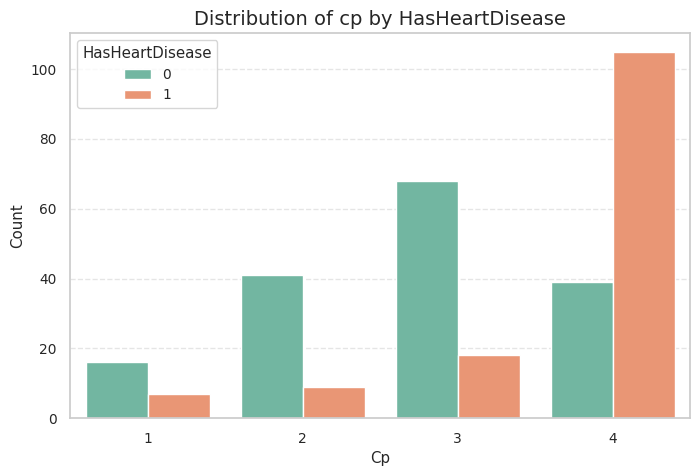

In [12]:
compare_categorical_distribution(heart_disease_df, 'cp', 'HasHeartDisease')

- This distribution aligns with clinical understanding:
  - Patients **without heart disease** typically report **typical or atypical angina** during exertion.
  - Patients **with heart disease** often present **asymptomatic or vague pain (type 4)**, complicating early detection.
- Therefore, **`cp` is a highly discriminative feature**, showing a strong relationship with the target variable (`HasHeartDisease`).

/content/drive/MyDrive/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance/utils.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=feature, palette='Set2')


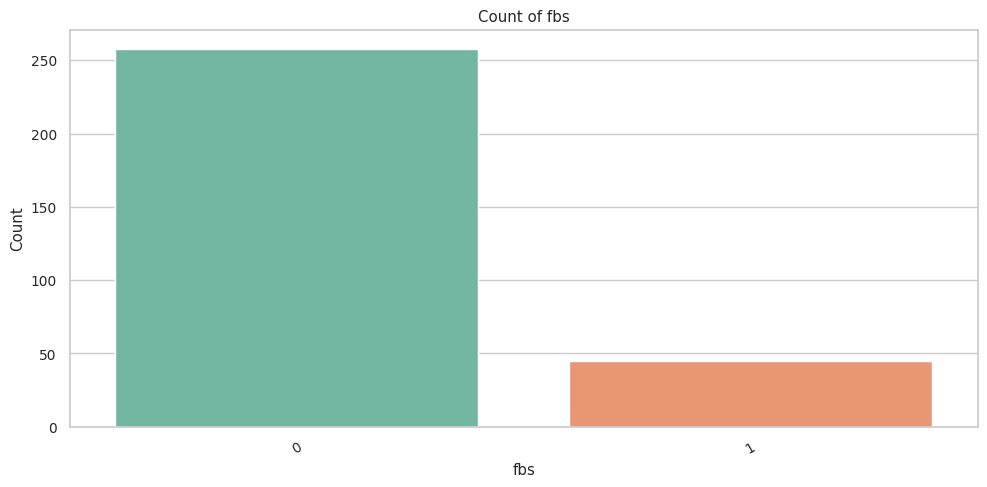

In [13]:
plot_feature_distribution_categorical(heart_disease_df, 'fbs')

/content/drive/MyDrive/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance/utils.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=feature, palette='Set2')


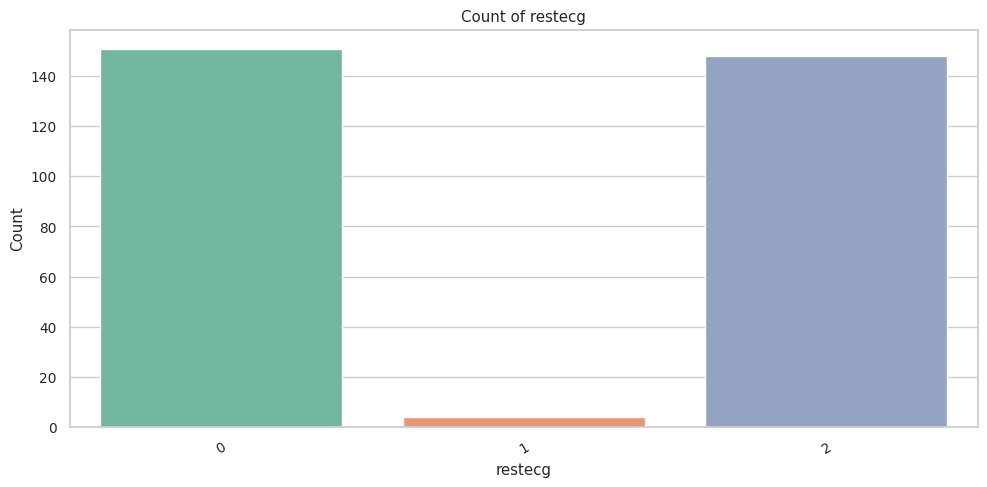

In [14]:
plot_feature_distribution_categorical(heart_disease_df, 'restecg')

/content/drive/MyDrive/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance/utils.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=feature, palette='Set2')


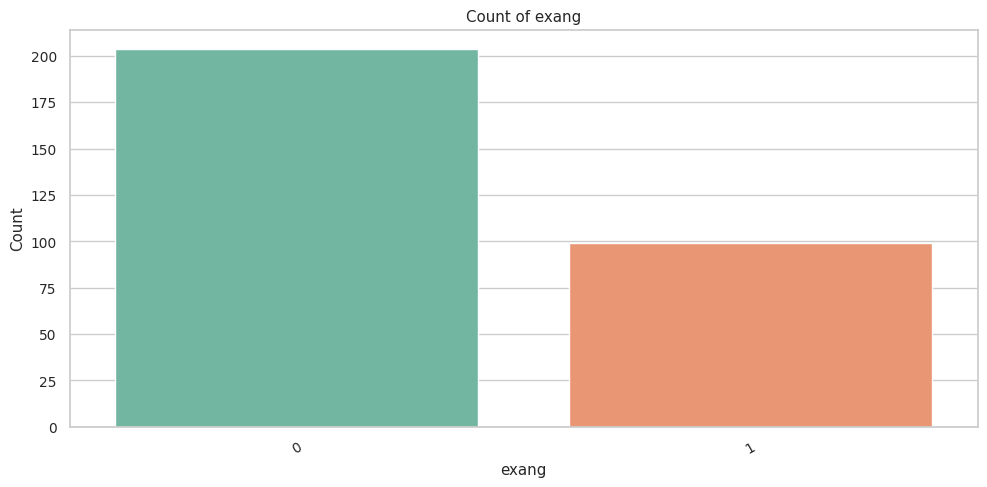

In [15]:
plot_feature_distribution_categorical(heart_disease_df, 'exang')

/content/drive/MyDrive/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance/utils.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=feature, palette='Set2')


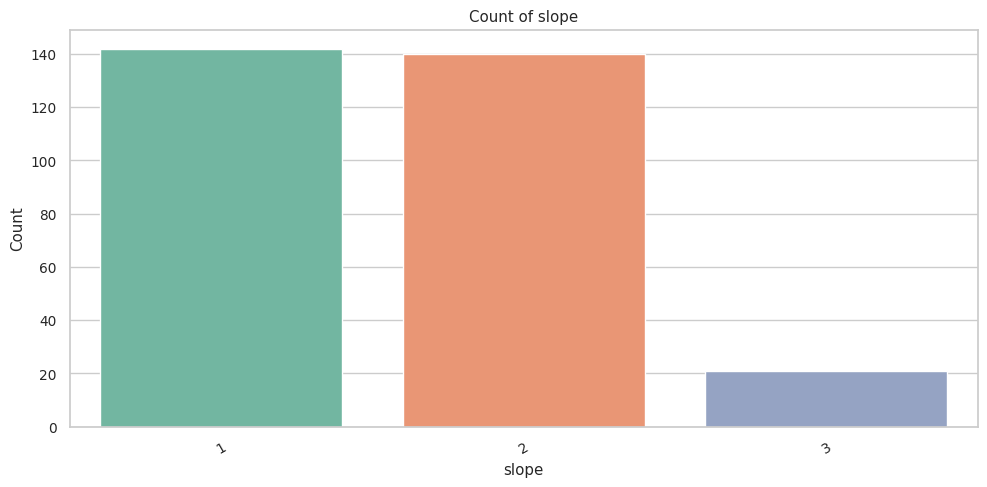

In [16]:
plot_feature_distribution_categorical(heart_disease_df, 'slope')

/content/drive/MyDrive/Counterfactual-Fairness-in-Health-Prediction-Models-under-Data-Imbalance/utils.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=feature, palette='Set2')


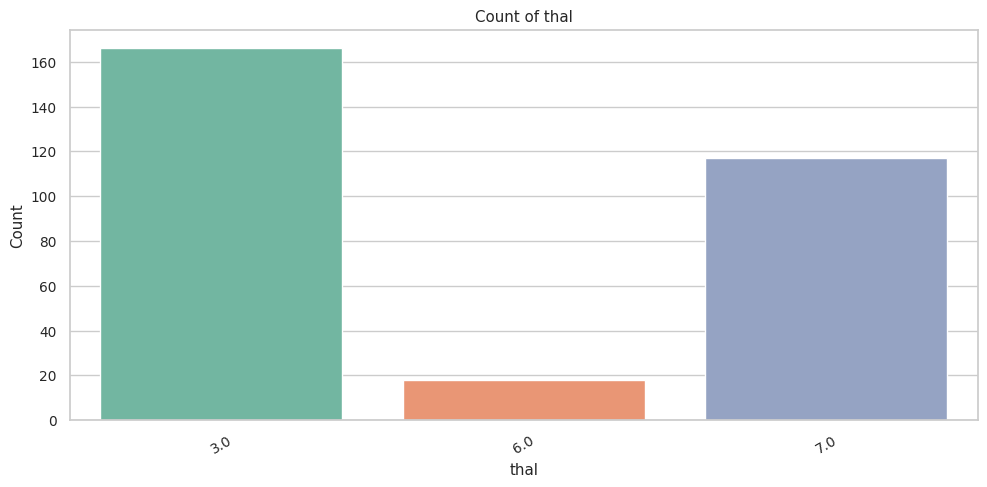

In [17]:
plot_feature_distribution_categorical(heart_disease_df, 'thal')

#### **Continuous Features**

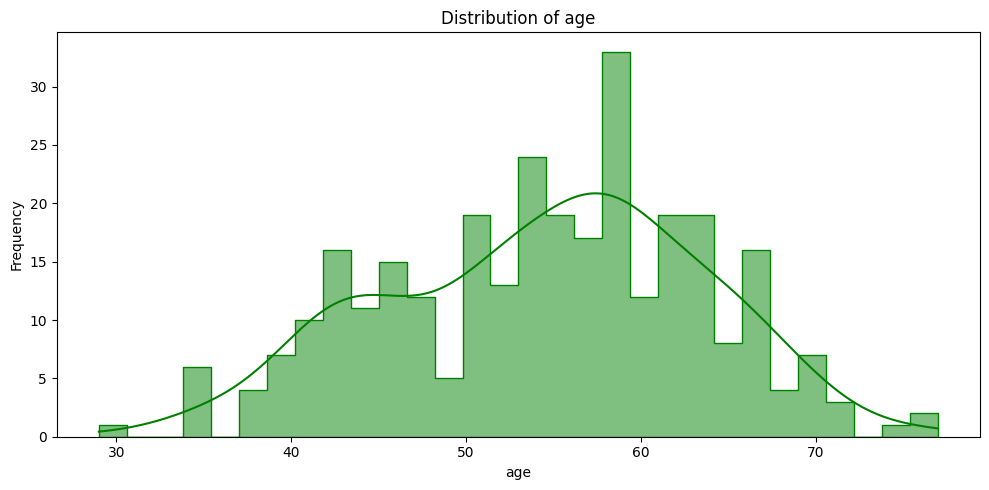

In [13]:
plot_feature_distribution_numeric(heart_disease_df, 'age')

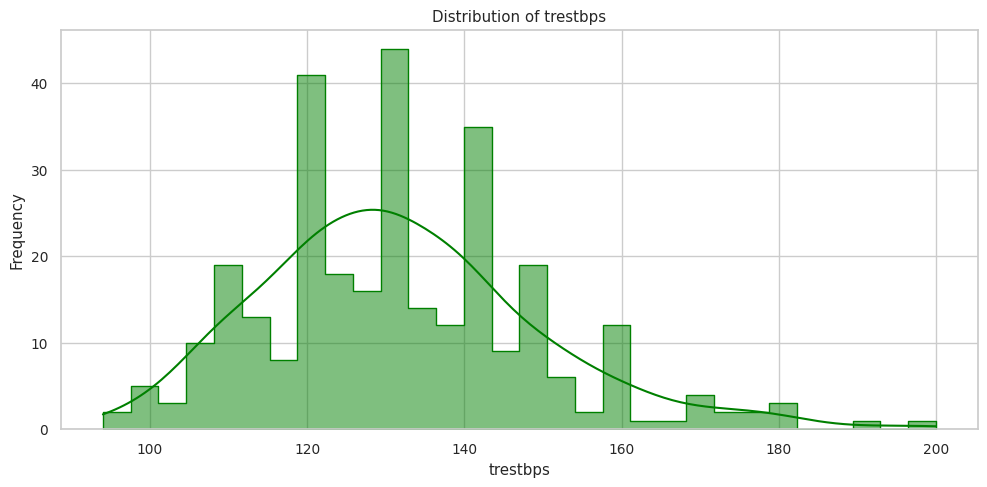

In [18]:
plot_feature_distribution_numeric(heart_disease_df, 'trestbps')

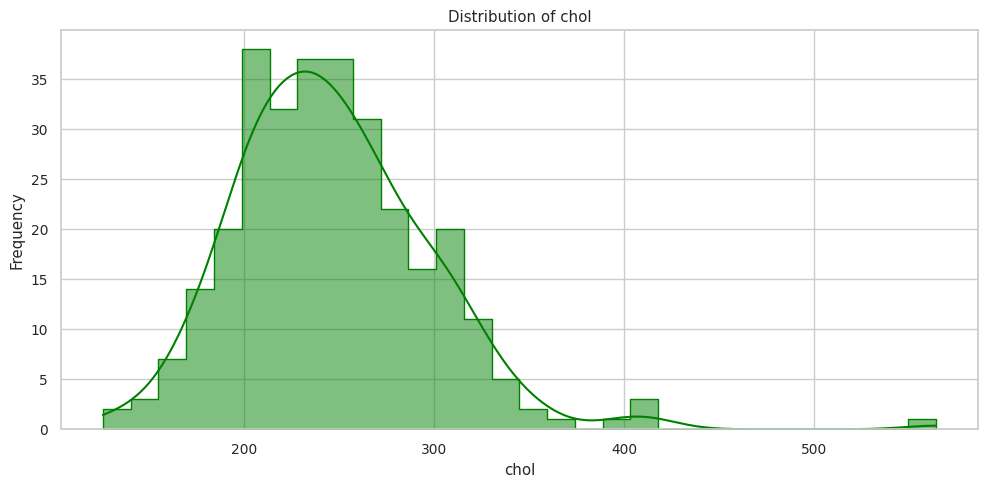

In [19]:
plot_feature_distribution_numeric(heart_disease_df, 'chol')

---
## 3. Preprocessing
---

### 3.1. Heart Disease
---

In [57]:
heart_disease_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


In [58]:
heart_disease_df['sex'].unique()

array([1, 0])

In [59]:
sex_mapping = {0: 'female', 1: 'male'}
heart_disease_df['sex_str'] = heart_disease_df['sex'].map(sex_mapping)
heart_disease_df['sex_str'].unique()

array(['male', 'female'], dtype=object)

In [60]:
heart_disease_df['num'].unique()

array([0, 2, 1, 3, 4])

In [62]:
heart_disease_df['ca'].fillna(heart_disease_df['ca'].median(), inplace=True)

/tmp/ipython-input-2385584266.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  heart_disease_df['ca'].fillna(heart_disease_df['ca'].median(), inplace=True)


In [63]:
heart_disease_df['thal'].fillna(heart_disease_df['thal'].median(), inplace=True)

/tmp/ipython-input-3768223545.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  heart_disease_df['thal'].fillna(heart_disease_df['thal'].median(), inplace=True)


In [64]:
heart_disease_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              303 non-null    int64  
 1   sex              303 non-null    int64  
 2   cp               303 non-null    int64  
 3   trestbps         303 non-null    int64  
 4   chol             303 non-null    int64  
 5   fbs              303 non-null    int64  
 6   restecg          303 non-null    int64  
 7   thalach          303 non-null    int64  
 8   exang            303 non-null    int64  
 9   oldpeak          303 non-null    float64
 10  slope            303 non-null    int64  
 11  ca               303 non-null    float64
 12  thal             303 non-null    float64
 13  sex_str          303 non-null    object 
 14  HasHeartDisease  303 non-null    int64  
dtypes: float64(3), int64(11), object(1)
memory usage: 35.6+ KB


---
### 3.2. Health Insurance
---

In [65]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  14604 non-null  float64
 1   sex                  15000 non-null  object 
 2   weight               15000 non-null  int64  
 3   bmi                  14044 non-null  float64
 4   hereditary_diseases  15000 non-null  object 
 5   no_of_dependents     15000 non-null  int64  
 6   smoker               15000 non-null  int64  
 7   city                 15000 non-null  object 
 8   bloodpressure        15000 non-null  int64  
 9   diabetes             15000 non-null  int64  
 10  regular_ex           15000 non-null  int64  
 11  job_title            15000 non-null  object 
 12  claim                15000 non-null  float64
dtypes: float64(3), int64(6), object(4)
memory usage: 1.5+ MB


In [66]:
insurance_df['sex'].unique()

array(['male', 'female'], dtype=object)

In [67]:
insurance_df['bmi'].fillna(insurance_df['bmi'].median(), inplace=True)

/tmp/ipython-input-217948996.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  insurance_df['bmi'].fillna(insurance_df['bmi'].median(), inplace=True)


---
## Modelling
---

In [25]:
X = df.drop(columns=['num', 'sex_str'])
y = df['num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.82      0.89        33
           1       0.82      0.96      0.89        28

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.90      0.89      0.89        61



In [26]:
df_test = pd.concat([X_test, y_test], axis=1)

In [27]:
from witwidget.notebook.visualization import WitConfigBuilder, WitWidget

# Convert your test data into the correct format
examples = df_test.values.tolist()

# Build configuration
config_builder = (
    WitConfigBuilder(examples, feature_names=df_test.columns.tolist())
    .set_target_feature('num')  # optional if you have the label in the data
    .set_model_type('classification')
    .set_custom_predict_fn(clf.predict_proba)
)

# Launch What-If Tool
WitWidget(config_builder)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
